## Exercise 1 — **Data transfer optimisations**

The goal of this exercise is to:
- learn how to minimize redundant main memory transfers and understand its importance;
- understand the limits of the *total memory throughput* metric for performance evaluation;
- learn how to compute the *effective memory throughput* and understand its interest;
- learn about GPU array and kernel programming on the way.

Prerequisites:
- the lecture 6 *Benchmarking memory copy and establishing peak memory access performance* ([`l7_1-gpu-memcopy.ipynb`](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/notebooks/l7_1-gpu-memcopy.ipynb))

[*This content is distributed under MIT licence. Authors: S. Omlin (CSCS), L. Räss (ETHZ).*](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/LICENSE.md)

### Getting started

👉 Download the [`lecture7_ex1.ipynb`](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/notebooks/lecture7_ex1.ipynb) notebook and edit it.

- Create a new folder in your GitHub repository for this week's (`lecture7`) exercises, including a `README.md` (as usual).
- Hand-in the finalised notebook in your GitHub lecture 7 folder and;
- Report the output of Task 7 in the `README.md`.

> 💡 note: Values reported in this exercise are for the Nvidia GH200 96GB GPU.

We will again use the packages `CUDA`, `BenchmarkTools` and `Plots` to create a little performance laboratory:

In [1]:
using IJulia
using CUDA
using BenchmarkTools
using Plots

Before we go further, make sure we select the GPU we want to run on (if running on a multi-GPU node). In the terminal or Julia REPL in shell mode (typing `;`), type `nvidia-smi` command to list visible GPUs. Remember the GPU_ID you want to use.

Then, in Julia, add following if you decide to, e.g., use GPU 0:

In [2]:
GPU_ID = 0
device!(GPU_ID)

CuDevice(0): NVIDIA GH200 120GB

> 💡 note: Having multiple users accessing the same GPU will result in severe performance deprecation.

Let us consider the following 2-D heat diffusion solver (the comments explain the code):

In [60]:
function diffusion2D()
    # Physics
    lam      = 1.0                                          # Thermal conductivity
    c0       = 2.0                                          # Heat capacity
    lx, ly   = 10.0, 10.0                                   # Length of computational domain in dimension x and y

    # Numerics
    nx, ny   = 32*2, 32*2                                   # Number of gridpoints in dimensions x and y
    nt       = 100                                          # Number of time steps
    dx       = lx/(nx-1)                                    # Space step in x-dimension
    dy       = ly/(ny-1)                                    # Space step in y-dimension
    _dx, _dy = 1.0/dx, 1.0/dy

    # Array initializations
    T    = CUDA.zeros(Float64, nx, ny)                      # Temperature
    Ci   = CUDA.zeros(Float64, nx, ny)                      # 1/Heat capacity
    qTx  = CUDA.zeros(Float64, nx-1, ny-2)                  # Heat flux, x component
    qTy  = CUDA.zeros(Float64, nx-2, ny-1)                  # Heat flux, y component
    dTdt = CUDA.zeros(Float64, nx-2, ny-2)                  # Change of Temperature in time

    # Initial conditions
    Ci .= 1/c0                                              # 1/Heat capacity (could vary in space)
    T  .= CuArray([10.0*exp(-(((ix-1)*dx-lx/2)/2)^2-(((iy-1)*dy-ly/2)/2)^2) for ix=1:size(T,1), iy=1:size(T,2)]) # Initialization of Gaussian temperature anomaly

    # Time loop
    dt  = min(dx^2,dy^2)/lam/maximum(Ci)/4.1                # Time step for 2D Heat diffusion
    opts = (aspect_ratio=1, xlims=(1, nx), ylims=(1, ny), clims=(0.0, 10.0), c=:davos, xlabel="Lx", ylabel="Ly") # plotting options
    for it = 1:nt
        diffusion2D_step!(T, Ci, qTx, qTy, dTdt, lam, dt, _dx, _dy) # Diffusion time step.
        if it % 10 == 0
            IJulia.clear_output(true)
            display(heatmap(Array(T)'; opts...))            # Visualization
            sleep(0.1)
        end
    end
end

diffusion2D (generic function with 1 method)

> 💡 note: Divisions are precomputed as they are slower than multiplications.

The function to compute an actual time step is still missing to complete this solver. It can be written, e.g., as follows with finite differences using GPU *array programming* (AP):

In [61]:
@views macro d_xa(A) esc(:( ($A[2:end  , :     ] .- $A[1:end-1, :     ]) )) end
@views macro d_xi(A) esc(:( ($A[2:end  ,2:end-1] .- $A[1:end-1,2:end-1]) )) end
@views macro d_ya(A) esc(:( ($A[ :     ,2:end  ] .- $A[ :     ,1:end-1]) )) end
@views macro d_yi(A) esc(:( ($A[2:end-1,2:end  ] .- $A[2:end-1,1:end-1]) )) end
@views macro  inn(A) esc(:( $A[2:end-1,2:end-1]                          )) end

@views function diffusion2D_step!(T, Ci, qTx, qTy, dTdt, lam, dt, _dx, _dy)
    @inbounds begin
        qTx     .= .-lam.*@d_xi(T).*_dx #1 write 1 read                             # Fourier's law of heat conduction: qT_x  = -λ ∂T/∂x
        qTy     .= .-lam.*@d_yi(T).*_dy    #1 write 1 read                          # ...                               qT_y  = -λ ∂T/∂y
        dTdt    .= @inn(Ci).*(.-@d_xa(qTx).*_dx .- @d_ya(qTy).*_dy) #1 write, 3 read # Conservation of energy:           ∂T/∂t = 1/cp (-∂qT_x/∂x - ∂qT_y/∂y)
        @inn(T) .= @inn(T) .+ dt.*dTdt     #1 write 2 reads                          # Update of temperature             T_new = T_old + ∂t ∂T/∂t
    end
end

diffusion2D_step! (generic function with 2 methods)

> 💡 note: We use everywhere views to avoid allocations of temporary arrays (see [here](https://docs.julialang.org/en/v1/manual/performance-tips/#man-performance-views) for more information).

> 💡 note: We use everywhere dots to fuse vectorized operations and avoid any allocations of temporary arrays (see [here](https://docs.julialang.org/en/v1/manual/performance-tips/#More-dots:-Fuse-vectorized-operations) for more information). We wrote all dots explicitly for clarity; the [macro `@.`](https://docs.julialang.org/en/v1/base/arrays/#Base.Broadcast.@__dot__) removes the need of writing all dots explicitly.

> 💡 note: We use simple macros to enable nice syntax, in particular macros can be used also on the left side of an equal sign (learn [here](https://docs.julialang.org/en/v1/manual/metaprogramming/#man-macros) more about macros).

Run now the 2-D heat diffusion solver to verify that it is working:

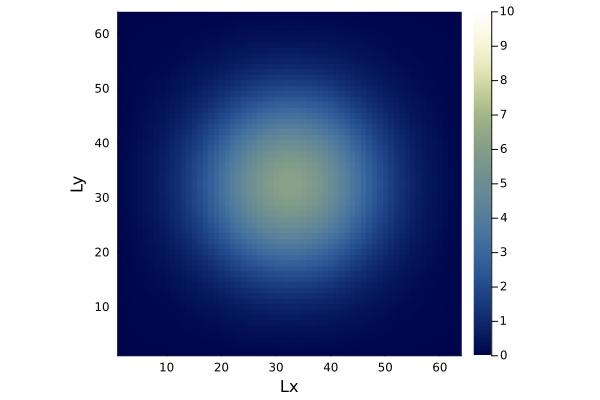

In [5]:
diffusion2D()

### Task 1 (Benchmarking)

Benchmark the function `diffusion2D_step!` using BenchmarkTools and compute a straightforward *lower bound of the total memory throughput*, `T_tot_lb`; then, compare it to the *peak memory throughput*, `T_peak`. You can compute `T_tot_lb` considering only full array reads and writes and knowing that there is no data reuse between different GPU array computation statements as each statement is translated into a separate and independently launched kernel (note that to obtain the actual `T_tot`, one would need to use a profiler).

Furthermore, use the `nx=ny` found best in the introduction notebook ([`l7_1-gpu-memcopy.ipynb`](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/notebooks/l7_1-gpu-memcopy.ipynb)) to allocate the necessary arrays if the amount of memory of your GPU allows it (else divide this `nx` and `ny` by 2).

To help you, there is already some code below to initialize the required arrays and scalars for the benchmarking.
> 💡 hint: Do not forget to interpolate these predefined variables into the benchmarking expression using `$` and note that you do not need to call the solver itself (`diffusion2D`)!

In [62]:
nx = ny = 16384# complete! #nx=ny=32; threads=(32, 8); blocks=(1, 4) ? 
T    = CUDA.rand(Float64, nx, ny);
Ci   = CUDA.rand(Float64, nx, ny);
qTx  = CUDA.zeros(Float64, nx-1, ny-2);
qTy  = CUDA.zeros(Float64, nx-2, ny-1);
dTdt = CUDA.zeros(Float64, nx-2, ny-2);
lam = _dx = _dy = dt = rand();

In [63]:
# solution
t_it = @belapsed begin 
        diffusion2D_step!($T, $Ci, $qTx, $qTy, $dTdt, $lam, $dt, $_dx, $_dy)
        CUDA.synchronize()
    end
#reads&writes: 11
T_tot_lb = 11.0 /1e9*nx*ny*sizeof(Float64)/t_it

println("Lower bound throughput (GB/s): ", T_tot_lb)
#compare to GPU peak
T_peak = 4000
println("Peak throughput (GB/s): ", T_peak)

println("Efficiency: ", 100 * T_tot_lb / T_peak, " %")


Lower bound throughput (GB/s): 2706.8506420117646
Peak throughput (GB/s): 4000
Efficiency: 67.67126605029411 %


Save the measured minimal runtime and the computed `T_tot_lb` in other variables (`t_it_task1` and `T_tot_lb_task1`) in order not to overwrite them later (adapt these two lines if you used other variable names!); moreover, we will remove the arrays we do no longer need in order to save space:

In [65]:
t_it_task1 = t_it
T_tot_lb_task1 = T_tot_lb
CUDA.unsafe_free!(qTx)
CUDA.unsafe_free!(qTy)
CUDA.unsafe_free!(dTdt)

`T_tot_lb` should be relatively close to `T_peak`. Nevertheless, one could do these computations at least three times faster. You may wonder why it is possible to predict that just looking at the code. It is because three of the four arrays that are updated every iteration are not computed based on their values in the previous iteration and their individual values could therefore be computed on-the-fly when needed or stored in the much faster on-chip memory as intermediate results; these three arrays would never need to be stored in main memory and read from there. Only the temperature array (`T`) needs inevitably to be read from main memory and written to it at every iteration as is computed based on its values from the previous iteration (and the entire temperature array is orders of magnitudes bigger than the available on-chip memory). In addition, the heat capacity array (`Ci`) needs to be entirely read at every iteration. To sum up, all but three of eleven full array memory reads or writes can be avoided. If we avoid them, we reduce the main memory accesses by more than a factor three and can therefore expect the code to be at least three times faster.

As a consequence, `T_tot` and `T_tot_lb` are often not good metrics to evaluate the optimality of an implementation. Based on these reflections, we will introduce a better metric for the performance evaluation of solvers as the above. But first, let us verify that we can indeed speed up these computations by a factor three or more.

With GPU kernel programming, we could do that as just described, fusing the four kernels that correspond to the four GPU array programming statements into one. However, we want to try an easier solution using GPU array programming at this point.

There is, however, no obvious way to compute values on-the-fly when needed or to store intermediate result on chip in order to achieve the above described. We can instead do the equivalent mathematically: we can substitute `qTx` and `qTy` into the expression to compute `dTdt` and then substitute this in turn into the expression to compute `T` to get:

$$ T_\mathrm{new} = T_\mathrm{old} + ∂t~\frac{1}{c_p} \left( -\frac{∂}{∂x} \left(-λ~\frac{∂T}{∂x}\right) -\frac{∂}{∂y} \left(-λ~\frac{∂T}{∂y}\right) \right) $$

Note that this would obviously be mathematically equivalent to the temperature update rule that we would obtain based on the commonly used heat diffusion equation **for constant and scalar** $λ$:

$$ T_\mathrm{new} = T_\mathrm{old} + ∂t~\frac{λ}{c_p} \left( \frac{∂^2T}{∂x^2} + \frac{∂^2T}{∂y^2} \right) $$

We will though use (2) in order not to make limiting assumptions and simplify the computations done in `diffusion2D_step!`, but to solely optimize data transfer.

We remove therefore the arrays `qTx`, `qTy` and `dTdt` in the main function of the 2-D heat diffusion solver as they are no longer needed; moreover, we introduce `T2` as a second array for the temperature. `T2` is needed to write newly computed temperature values to a different location then the old temperature values while they are still needed for computations (else we would perform the spatial derivatives partly with new temperature values instead of only with old ones). Here is the resulting main function:

In [66]:
function diffusion2D()
    # Physics
    lam      = 1.0                                          # Thermal conductivity
    c0       = 2.0                                          # Heat capacity
    lx, ly   = 10.0, 10.0                                   # Length of computational domain in dimension x and y

    # Numerics
    nx, ny   = 32*2, 32*2                                   # Number of gridpoints in dimensions x and y
    nt       = 100                                          # Number of time steps
    dx       = lx/(nx-1)                                    # Space step in x-dimension
    dy       = ly/(ny-1)                                    # Space step in y-dimension
    _dx, _dy = 1.0/dx, 1.0/dy

    # Array initializations
    T    = CUDA.zeros(Float64, nx, ny)                      # Temperature
    T2   = CUDA.zeros(Float64, nx, ny)                      # 2nd array for Temperature
    Ci   = CUDA.zeros(Float64, nx, ny)                      # 1/Heat capacity

    # Initial conditions
    Ci .= 1/c0                                              # 1/Heat capacity (could vary in space)
    T  .= CuArray([10.0*exp(-(((ix-1)*dx-lx/2)/2)^2-(((iy-1)*dy-ly/2)/2)^2) for ix=1:size(T,1), iy=1:size(T,2)]) # Initialization of Gaussian temperature anomaly
    T2 .= T;                                                 # Assign also T2 to get correct boundary conditions.

    # Time loop
    dt  = min(dx^2,dy^2)/lam/maximum(Ci)/4.1                # Time step for 2D Heat diffusion
    opts = (aspect_ratio=1, xlims=(1, nx), ylims=(1, ny), clims=(0.0, 10.0), c=:davos, xlabel="Lx", ylabel="Ly") # plotting options
    for it = 1:nt
        diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)     # Diffusion time step.
        if it % 10 == 0
            IJulia.clear_output(true)
            display(heatmap(Array(T)'; opts...))            # Visualization
            sleep(0.1)
        end
        T, T2 = T2, T                                       # Swap the aliases T and T2 (does not perform any array copy)
    end
end

diffusion2D (generic function with 1 method)

### Task 2 (GPU array programming)

Write the corresponding function `diffusion2D_step!` to compute a time step using the temperature update rule (2); write it in **a single GPU array programming statement** (it should go over multiple lines) and without using any helper macros or functions in order to be sure that all computations will get fused into one single kernel.
> 💡 hint: Make sure to use the correct function signature: `diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)`.

> 💡 hint: To verify that it does the right computations, you can launch `diffusion2D()`.

> 💡 hint: Only add the `@inbounds` macro to the function once you have verified that it work as they should.

In [75]:
# solution
@views function diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)
    @inbounds T2[2:end-1,2:end-1] .= T[2:end-1,2:end-1] .+ dt.* (Ci[2:end-1, 2:end-1]) * lam .* 
        (
            #d²T/dx²
            (T[3:end, 2:end-1] .- 2 .* T[2:end-1, 2:end-1] .+ T[1:end-2, 2:end-1] ).*_dx .*_dx 
            .+
            #d²T/dy²
            (T[ 2:end-1, 3:end] .- 2 .* T[2:end-1, 2:end-1] .+ T[ 2:end-1, 1:end-2] ).*_dy .*_dy
        )#1 write 2 reads
end

#diffusion2D()

diffusion2D_step! (generic function with 2 methods)

In [76]:
nx = ny = 16384# complete! #nx=ny=32; threads=(32, 8); blocks=(1, 4) ? 
T    = CUDA.rand(Float64, nx, ny);
Ci   = CUDA.rand(Float64, nx, ny);
T2   = CUDA.zeros(Float64, nx, ny)  
#T2   .= T
lam = _dx = _dy = dt = rand();
#diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)

### Task 3 (Benchmarking)

Benchmark the new function `diffusion2D_step!` and compute the runtime speed-up compared to the function benchmarked in Task 1. Then, compute `T_tot_lb` and the ratio between this `T_tot_lb` and the one obtained in Task 1.

In [77]:
# solution
T2 = T#?
t_it = @belapsed begin diffusion2D_step!($T2, $T, $Ci, $lam, $dt, $_dx, $_dy); synchronize() end
speedup = t_it_task1/t_it
#write for T2 + read T2 + read for Ci
T_tot_lb = 3.0 / 1e9*nx*ny*sizeof(Float64)/t_it
ratio_T_tot_lb = T_tot_lb / T_tot_lb_task1
print("speedup: $(speedup), ratio_T_tot_lb = $(ratio_T_tot_lb)")

speedup: 0.2971571762065459, ratio_T_tot_lb = 0.0810428662381489

Save the measured minimal runtime and the computed T_tot_lb in other variables (`t_it_task3` and `T_tot_lb_task3`) in order not to overwrite them later (adapt these two lines if you used other variable names!):

In [78]:
t_it_task3 = t_it
T_tot_lb_task3 = T_tot_lb
speeduptask3 = speedup

0.2971571762065459

You should have observed a significant speedup even though `T_tot_lb` has probably decreased. This empirically confirms our earlier statement that `T_tot_lb` and consequently also `T_tot` (measured with a profiler) are often not good metrics to evaluate the **optimality** of an implementation.

A good metric should certainly be tightly linked to observed runtime. We will now try to further speedup the function `diffusion2D_step!` using straightforward GPU kernel programming.

### Task 4 (GPU kernel programming)

Rewrite the function `diffusion2D_step!` using GPU kernel programming: from within this function, call a GPU kernel, which updates the temperature using update rule (2) (you also need to write this kernel); for simplicity's sake, hardcode the kernel launch parameter `threads` found best in the introduction ([`l6_1-gpu-memcopy.ipynb`](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/notebooks/l7_1-gpu-memcopy.ipynb)) into the function and compute `blocks` accordingly in order to have it work with the existing main function `diffusion2` (use the function `size` instead of `nx` and `ny` to compute `blocks`).
> 💡 hint: You can base yourself on the kernel `memcopy_triad_KP!` from the introdution notebook to help you remember the very basics of GPU kernel programming.

> 💡 hint: In this kind of kernels, the computations are described for one array cell (here `T2[ix,iy]`) rather than for whole arrays - just like in a for loop; moreover, if-statements allow to ensure to remain within the array boundaries (in for loop this is achieved with the loop ranges).

> 💡 hint: To verify that it does the right computations, you can launch `diffusion2D()` (as in task 2).

> 💡 hint: Add the `@inbounds` macro direcly in front of the Temperature assignement (`T2[ix,iy]`) as else it does not propagate to the computations (more information on the propagation of `@inbounds` can be found [here](https://docs.julialang.org/en/v1/devdocs/boundscheck/)).

> 💡 hint: Only add the `@inbounds` macro to the function once you have verified that it work as they should (as in task 2).

In [79]:
# solution
function diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)
    threads = (32, 1)
    blocks  = (size(T, 1)÷threads[1], size(T, 2)÷threads[2])
    @cuda threads=threads blocks=blocks update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
end


function update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
    ix = (blockIdx().x -1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y -1) * blockDim().y + threadIdx().y
    if 2 <= ix <= size(T,1)-1 && 2 <= iy <= size(T,2)-1
        @inbounds T2[ix,iy] = T[ix,iy] + dt*(Ci[ix,iy] * lam .* 
        (#todo: add @view ?
            #d²T/dx²
            (T[ix+1, iy] - 2 * T[ix, iy] + T[ix-1, iy] )*_dx *_dx 
            +
            #d²T/dy²
            (T[ ix, iy+1] - 2 * T[ix, iy] + T[ ix, iy-1] )*_dy *_dy
        ) )
    end
    return nothing
end

#diffusion2D()

update_temperature! (generic function with 1 method)

### Task 5 (Benchmarking)

Just like in Task 3, benchmark the new function `diffusion2D_step!` and compute the runtime speedup compared to the function benchmarked in Task 1. Then, compute `T_tot_lb` and the ratio between this `T_tot_lb` and the one obtained in Task 1.

In [80]:
# solution
t_it = @belapsed begin diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy); synchronize() end
speedup = t_it_task1/t_it
#write: T, readonly: T2, Ci
T_tot_lb = 3.0 /1e9*nx*ny*sizeof(Float64)/t_it
ratio_T_tot_lb = T_tot_lb / T_tot_lb_task1
print("speedup: $(speedup), ratio_T_tot_lb = $(ratio_T_tot_lb)")

speedup: 1.7233234214867614, ratio_T_tot_lb = 0.4699972967691167

The runtime speedup is probably even higher, even though `T_tot_lb` is probably somewhat similar to the one obtained in task 1. We will now define a better metric for the performance evaluation of solvers like the one above, which is always proportional to observed runtime.

To this aim, let us recall first the reflections made after benchmarking the original GPU array programming code in Task 1:
> three of the four arrays that are updated every iteration are not computed based on their values in the previous iteration and their individual values could therefore be computed on-the-fly when needed or stored in the much faster on-chip memory as intermediate results; these three arrays would never need to be stored in main memory and read from there. Only the temperature array (`T`) needs inevitably to be read from main memory and written to it at every iteration as is computed based on its values from the previous iteration (and the entire temperature array is orders of magnitudes bigger than the available on-chip memory). In addition, the heat capacity array (`Ci`) needs to be entirely read at every iteration. To sum up, all but three of eleven full array memory reads or writes can be avoided. If we avoid them, we reduce the main memory accesses by more than a factor three and can therefore expect the code to be at least three times faster.

With this in mind, we will now define the metric, which we call the *effective memory throughput*, $T_\mathrm{eff}$.

The effective memory access, $A_\mathrm{eff}$ [GB], is the the sum of twice the memory footprint of the unknown fields, $D_\mathrm{u}$, (fields that depend on their own history and that need to be updated every iteration) and the known fields, $D_\mathrm{k}$, that do not change every iteration. The effective memory access divided by the execution time per iteration, t_it [sec], defines the effective memory throughput, $T_\mathrm{eff}$ [GB/s]:

$$ A_\mathrm{eff} = 2~D_\mathrm{u} + D_\mathrm{k} $$

$$ T_\mathrm{eff} = \frac{A_\mathrm{eff}}{t_\mathrm{it}} $$

The upper bound of $T_\mathrm{eff}$ is $T_\mathrm{peak}$ as measured e.g. by [McCalpin, 1995](https://www.researchgate.net/publication/51992086_Memory_bandwidth_and_machine_balance_in_high_performance_computers) for CPUs or a GPU analogue. Defining the $T_\mathrm{eff}$ metric, we assume that 1) we evaluate an iterative stencil-based solver, 2) the problem size is much larger than the cache sizes and 3) the usage of time blocking is not feasible or advantageous (which is a reasonable assumption for real-world applications). An important concept is not to include fields within the effective memory access that do not depend on their own history (e.g. fluxes); such fields can be re-computed on the fly or stored on-chip. Defining a theoretical upper bound for $T_\mathrm{eff}$ that is closer to the real upper bound is work in progress.

### Task 6 (Benchmarking)

Compute the effective memory throughput, $T_\mathrm{eff}$, for the solvers benchmarked in Task 1, 3 and 5 (you do not need to redo any benchmarking, but you can compute it based on the saved measured runtimes in these three tasks) and recompute the speedup achieved in Task 3 and 5 based on $T_\mathrm{eff}$ instead of based on the runtime; compare the newly computed speedups with the previous.

In [81]:
# solution
#Du = T, qTx, qTy, dTdt.  Dk = Ci
T_eff_task1 = 3/1e9*nx*ny*sizeof(Float64) /t_it_task1
#Du = T, Dk = 1
T_eff_task3 = (2+1) /1e9*nx*ny*sizeof(Float64)/t_it_task3
#Du = T, Dk = 1
T_eff_task5 = (2+1)/1e9*nx*ny*sizeof(Float64) /t_it
speedup_Teff_task3 = T_eff_task3/T_eff_task1
speedup_Teff_task5 = T_eff_task5/T_eff_task1
print("speedup task 3: $(speedup_Teff_task3) \n")
print("speedup task 5: $(speedup_Teff_task5) ")

speedup task 3: 0.29715717620654597 
speedup task 5: 1.7233234214867612 

Did the speedups you recomputed differ from the previous ones?

If yes, then you made a mistake. Due to the way $T_\mathrm{eff}$ is defined, it is always proportional to observed runtime and it reflects therefore any runtime speedup by 100% while the problem size and the number data type are kept fixed. If, however, you increase these parameters, then T_eff will reflect the additionally performed work and it therefore enables the comparison of the performance achieved in function of the problem size (or number data type). It even allows to compare the performance of different solvers or implementations to a certain point.

Most importantly though, comparing a measured $T_\mathrm{eff}$ with $T_\mathrm{peak}$ informs us about room for performance improvement.

### Task 7 (Benchmarking)

Compute by how much percent you can improve the performance of the solver at most:

In [83]:
#solution for GH200
T_peak = 4000 # Peak memory throughput of the Tesla GH200 GPU
@show T_eff_task5/T_peak

T_eff_task5 / T_peak = 0.31805312112581935


0.31805312112581935

Report the value and potentially a short explanation in the `README.md` on GitHub, within lecture 7 folder (do not forget to upload this finalised notebook as well).